# Interactive Analysis: Sentiment & Per-outlet Overview

This notebook loads the aggregated sentiment outputs and per-outlet summaries created by `analysis_sentiment_overview.py`. Use the cells below to explore per-outlet sentiment breakdowns and sample reviews.

In [48]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
sns.set(style='whitegrid')

# Robustly locate the repository root so the notebook works whether it's run from
# the project root or from the 'Google Reviews' folder in VS Code/Jupyter.
cwd = Path().resolve()
repo_root = None
target_rel = Path('Reviews') / 'Overview' / 'per_outlet_sentiment_summary.csv'
p = cwd
# Walk upwards up to 6 levels to find the target file
for _ in range(6):
    candidate = p / target_rel
    if candidate.exists():
        repo_root = p
        break
    p = p.parent
# Fallback: assume repo root is parent of current folder
if repo_root is None:
    repo_root = cwd.parent

OUT_DIR = repo_root / 'Reviews' / 'Overview'
PER_OUTLET_CSV = OUT_DIR / 'per_outlet_sentiment_summary.csv'
REVIEWS_DIR = repo_root / 'Reviews' / 'All'

if not PER_OUTLET_CSV.exists():
    raise FileNotFoundError(f'Missing per-outlet summary CSV at {PER_OUTLET_CSV}. Run analysis_sentiment_overview.py first.')

per_outlet = pd.read_csv(str(PER_OUTLET_CSV))
per_outlet.head(20)

FileNotFoundError: Missing per-outlet summary CSV at /Users/breann/Documents/GitHub/IS434-Anytime-Fitness/Reviews/Overview/per_outlet_sentiment_summary.csv. Run analysis_sentiment_overview.py first.

Saved top 20 outlets with sentiment: /Users/breann/Documents/GitHub/IS434-Anytime-Fitness/Google-Reviews/Reviews/Overview/top_20_outlets_with_sentiment.csv


<Figure size 1200x800 with 0 Axes>

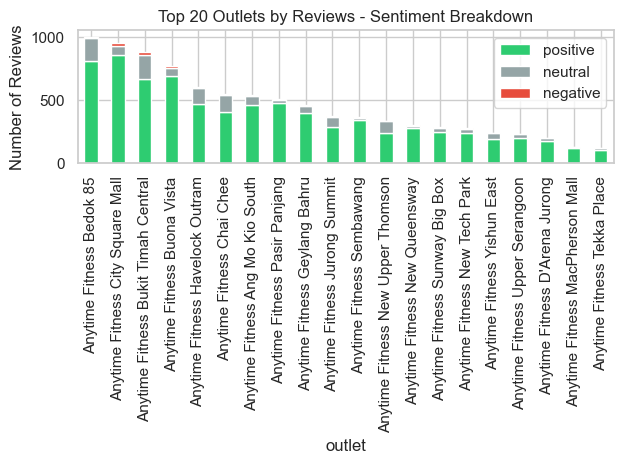

Saved stacked sentiment chart: /Users/breann/Documents/GitHub/IS434-Anytime-Fitness/Google-Reviews/Reviews/Overview/sentiment_by_outlet_top20.png


,avg_rating,total_reviews,positive,neutral,negative,no_text,pct_positive,pct_neutral,pct_negative,google_rating,rating_diff
outlet,,,,,,,,,,,
Anytime Fitness MacPherson Mall,4.97,126,122,2,2,0,96.83,1.59,1.59,5.0,-0.03
Anytime Fitness Bedok 85,4.94,1003,810,184,9,147,80.76,18.34,0.90,4.9,0.04
Anytime Fitness City Square Mall,4.86,953,858,75,20,52,90.03,7.87,2.10,4.9,-0.04
Anytime Fitness Bukit Timah Central,4.90,882,671,189,22,164,76.08,21.43,2.49,4.9,0.00
Anytime Fitness Buona Vista,4.86,773,691,62,20,40,89.39,8.02,2.59,4.9,-0.04
Anytime Fitness Havelock Outram,4.91,606,472,125,9,99,77.89,20.63,1.49,4.9,0.01
Anytime Fitness Ang Mo Kio South,4.88,539,463,66,10,54,85.90,12.24,1.86,4.9,-0.02
Anytime Fitness Pasir Panjang,4.86,511,477,23,11,2,93.35,4.50,2.15,4.9,-0.04
Anytime Fitness Geylang Bahru,4.87,463,400,56,7,41,86.39,12.10,1.51,4.9,-0.03


In [52]:
# Now sorted by ranking, top 20 
import os
import glob
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

sns.set(style='whitegrid')

# -----------------------------
# Define directories
# -----------------------------
BASE_DIR = os.getcwd()  # current working directory as base
REVIEWS_DIR = os.path.join(BASE_DIR, 'Reviews', 'All')
OUT_DIR = os.path.join(BASE_DIR, 'Reviews', 'Overview')
os.makedirs(OUT_DIR, exist_ok=True)

# -----------------------------
# Load top 20 outlets from previous CSV
# -----------------------------
top_20_file = os.path.join(BASE_DIR, 'Outlets', 'top_20_outlets.csv')
top_outlets_df = pd.read_csv(top_20_file, dtype=str)
top_outlets_df = top_outlets_df[['name','rating']].rename(columns={'name':'outlet','rating':'google_rating'})
top_outlets_df['outlet'] = top_outlets_df['outlet'].str.strip()
top_outlets_df['google_rating'] = pd.to_numeric(top_outlets_df['google_rating'], errors='coerce')

# -----------------------------
# Load all review CSVs
# -----------------------------
csvs = glob.glob(os.path.join(REVIEWS_DIR, '*_reviews.csv'))
if not csvs:
    raise SystemExit("No review CSVs found in Reviews/All/. Please check your files.")

dfs = []
for file in csvs:
    df = pd.read_csv(file)
    df['source_file'] = os.path.basename(file)
    dfs.append(df)

all_reviews = pd.concat(dfs, ignore_index=True)
all_reviews['text'] = all_reviews['text'].fillna('').astype(str)

# Filter only reviews for top 20 outlets
all_reviews['outlet'] = all_reviews.get('outlet', all_reviews['source_file'].str.replace('_reviews.csv',''))
all_reviews['outlet'] = all_reviews['outlet'].str.strip()
all_reviews = all_reviews[all_reviews['outlet'].isin(top_outlets_df['outlet'])]

# -----------------------------
# Parse numeric rating from reviews
# -----------------------------
def parse_rating_value(x):
    if pd.isna(x):
        return None
    s = str(x).strip()
    if s in ('','nan','none'):
        return None
    s = s.replace('/5','').replace('out of 5','').strip()
    if '★' in s:
        return float(s.count('★'))
    m = re.search(r'[\d\.]+', s)
    return float(m.group(0)) if m else None

if 'rating' in all_reviews.columns:
    all_reviews['rating_num'] = all_reviews['rating'].apply(parse_rating_value)
else:
    all_reviews['rating_num'] = pd.NA

# -----------------------------
# Compute VADER sentiment
# -----------------------------
analyzer = SentimentIntensityAnalyzer()
all_reviews['vader_compound'] = all_reviews['text'].apply(lambda t: analyzer.polarity_scores(t)['compound'])

def vader_label(c):
    if c >= 0.05:
        return 'positive'
    elif c <= -0.05:
        return 'negative'
    return 'neutral'

all_reviews['vader_cat'] = all_reviews['vader_compound'].apply(vader_label)

# -----------------------------
# Per-outlet summary
# -----------------------------
summary_rows = []
grouped = all_reviews.groupby('outlet')
for outlet, g in grouped:
    total = len(g)
    pos = (g['vader_cat']=='positive').sum()
    neu = (g['vader_cat']=='neutral').sum()
    neg = (g['vader_cat']=='negative').sum()
    no_text = (g['text']=='').sum()
    rating_vals = pd.to_numeric(g['rating_num'].dropna(), errors='coerce')
    avg_rating = float(rating_vals.mean()) if not rating_vals.empty else None

    summary_rows.append({
        'outlet': outlet,
        'avg_rating': round(avg_rating,2) if avg_rating is not None else None,
        'total_reviews': total,
        'positive': int(pos),
        'neutral': int(neu),
        'negative': int(neg),
        'no_text': int(no_text),
        'pct_positive': round(pos/total*100,2) if total else 0.0,
        'pct_neutral': round(neu/total*100,2) if total else 0.0,
        'pct_negative': round(neg/total*100,2) if total else 0.0
    })

per_outlet_df = pd.DataFrame(summary_rows).sort_values('total_reviews', ascending=False)

# -----------------------------
# Merge with Google ratings
# -----------------------------
per_outlet_df = per_outlet_df.merge(
    top_outlets_df[['outlet','google_rating']],
    on='outlet',
    how='left'
)

per_outlet_df['rating_diff'] = per_outlet_df['avg_rating'] - per_outlet_df['google_rating']

# -----------------------------
# Save outputs
# -----------------------------
top_outlets_csv = os.path.join(OUT_DIR, 'top_20_outlets_with_sentiment.csv')
per_outlet_df.to_csv(top_outlets_csv, index=False)

print(f"Saved top 20 outlets with sentiment: {top_outlets_csv}")

# -----------------------------
# Plot stacked sentiment for top 20
# -----------------------------
stacked_path = os.path.join(OUT_DIR, 'sentiment_by_outlet_top20.png')
top_df = per_outlet_df.set_index('outlet')
for col in ['positive','neutral','negative']:
    if col not in top_df.columns:
        top_df[col] = 0

plt.figure(figsize=(12,8))
top_df[['positive','neutral','negative']].plot(kind='bar', stacked=True,
                                            color=['#2ecc71','#95a5a6','#e74c3c'])
plt.title('Top 20 Outlets by Reviews - Sentiment Breakdown')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()
plt.close()
print(f"Saved stacked sentiment chart: {stacked_path}")

top_df.sort_values(['google_rating', 'total_reviews'], ascending=[False, False]).head(20)


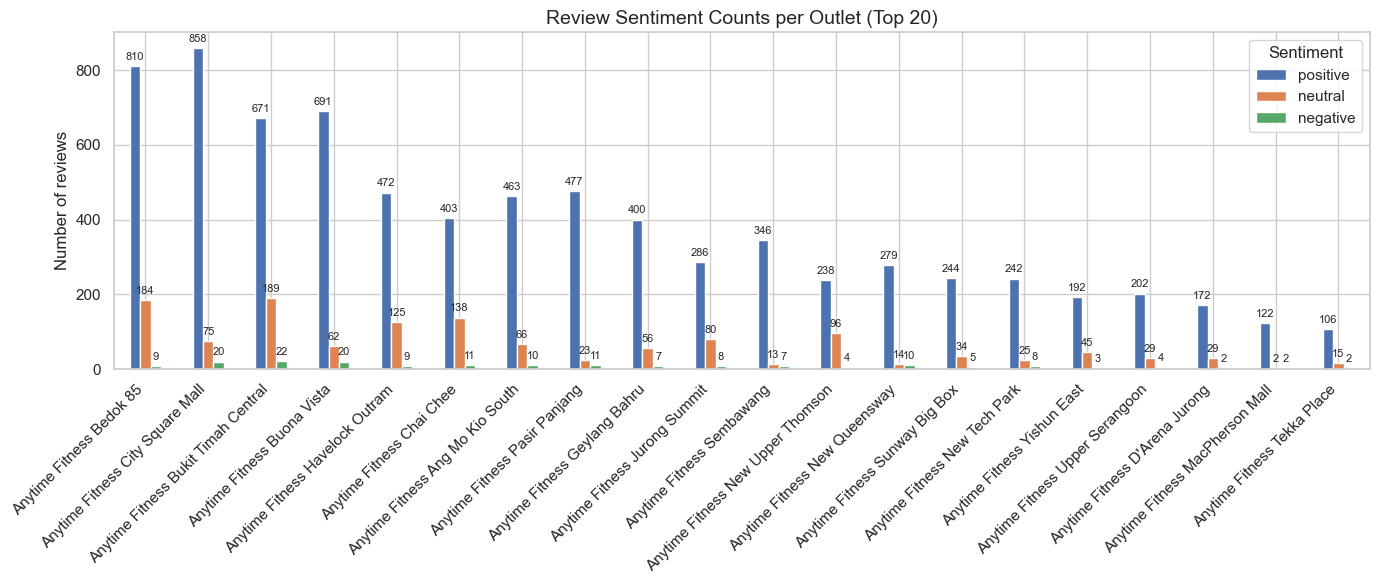

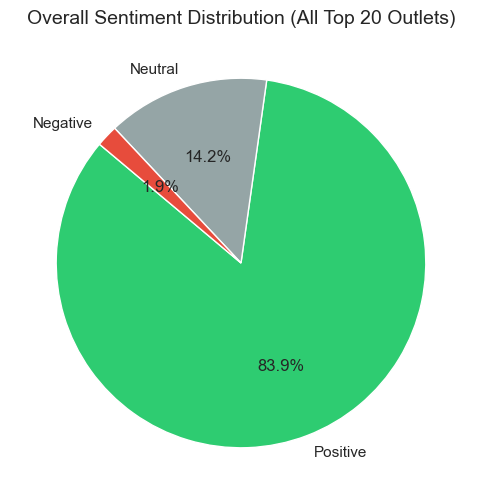

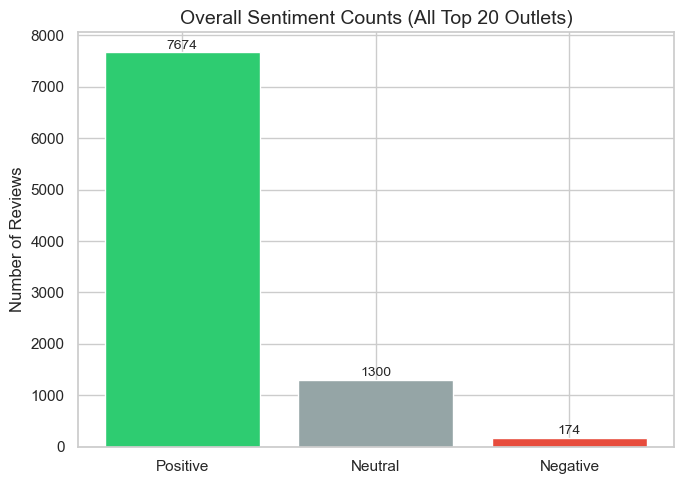

In [34]:
# Plot grouped bars of positive/neutral/negative counts per outlet (top 20)
plot_df = top_df[['positive', 'neutral', 'negative']]

ax = plot_df.plot(kind='bar', figsize=(14,6))
ax.set_title('Review Sentiment Counts per Outlet (Top 20)', fontsize=14)
ax.set_ylabel('Number of reviews')
ax.set_xlabel('')
ax.legend(title='Sentiment')

plt.xticks(rotation=45, ha='right')

# annotate each bar with its count
for p in ax.patches:
    height = p.get_height()
    if height is None:
        continue
    # skip zero-height bars if you prefer
    if height != 0:
        ax.annotate(f'{int(height)}',
                    xy=(p.get_x() + p.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# --- OVERALL SENTIMENT SPLIT (Pie + Bar) ---
# Sum the sentiment counts across all top 20 outlets
total_positive = top_df['positive'].sum()
total_neutral = top_df['neutral'].sum()
total_negative = top_df['negative'].sum()

# Create dictionary of totals
sentiment_totals = {
    'Positive': total_positive,
    'Neutral': total_neutral,
    'Negative': total_negative
}

# --- PIE CHART ---
plt.figure(figsize=(6,6))
plt.pie(
    sentiment_totals.values(),
    labels=sentiment_totals.keys(),
    autopct='%1.1f%%',
    startangle=140,
    colors=['#2ecc71', '#95a5a6', '#e74c3c']
)
plt.title('Overall Sentiment Distribution (All Top 20 Outlets)', fontsize=14)
plt.show()

# --- BAR CHART ---
plt.figure(figsize=(7,5))
plt.bar(sentiment_totals.keys(), sentiment_totals.values(), color=['#2ecc71', '#95a5a6', '#e74c3c'])
plt.title('Overall Sentiment Counts (All Top 20 Outlets)', fontsize=14)
plt.ylabel('Number of Reviews')

# Add text labels above bars
for i, (sentiment, count) in enumerate(sentiment_totals.items()):
    plt.text(i, count + 10, str(int(count)), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

Saved per-outlet summary: /Users/breann/Documents/GitHub/IS434-Anytime-Fitness/Google-Reviews/Reviews/Overview/bottom_per_outlet_sentiment_summary.csv
Saved bottom 20 outlets with sentiment: /Users/breann/Documents/GitHub/IS434-Anytime-Fitness/Google-Reviews/Reviews/Overview/bottom_20_outlets_with_sentiment.csv


<Figure size 1200x800 with 0 Axes>

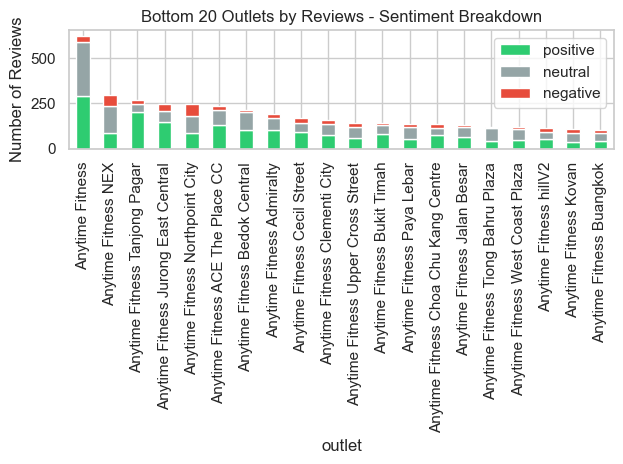

,avg_rating,total_reviews,positive,neutral,negative,no_text,pct_positive,pct_neutral,pct_negative,google_rating,rating_diff
outlet,,,,,,,,,,,
Anytime Fitness Northpoint City,3.00,244,84,97,63,85,34.43,39.75,25.82,3.0,0.00
Anytime Fitness NEX,3.06,295,88,147,60,124,29.83,49.83,20.34,3.1,-0.04
Anytime Fitness hillV2,3.16,112,53,40,19,32,47.32,35.71,16.96,3.2,-0.04
Anytime Fitness Upper Cross Street,3.52,142,58,60,24,53,40.85,42.25,16.90,3.5,0.02
Anytime Fitness Kovan,3.67,107,38,47,22,41,35.51,43.93,20.56,3.7,-0.03
Anytime Fitness Paya Lebar,3.69,138,51,70,17,63,36.96,50.72,12.32,3.7,-0.01
Anytime Fitness Jurong East Central,3.90,249,149,61,39,45,59.84,24.50,15.66,3.9,0.00
Anytime Fitness Buangkok,4.03,101,41,45,15,38,40.59,44.55,14.85,4.0,0.03
Anytime Fitness Choa Chu Kang Centre,4.07,134,77,36,21,29,57.46,26.87,15.67,4.0,0.07


In [ ]:
# # Now sorted by ranking, bottom 20
import os
import glob
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

sns.set(style='whitegrid')

# -----------------------------
# Define directories
# -----------------------------
BASE_DIR = os.getcwd()  # current working directory as base
REVIEWS_DIR = os.path.join(BASE_DIR, 'Reviews', 'All')
OUT_DIR = os.path.join(BASE_DIR, 'Reviews', 'Overview')
os.makedirs(OUT_DIR, exist_ok=True)

# -----------------------------
# Load bottom 20 outlets from previous CSV
# -----------------------------
bottom_20_file = os.path.join(BASE_DIR, 'Outlets', 'bottom_20_outlets.csv')
bottom_outlets_df = pd.read_csv(bottom_20_file, dtype=str)
bottom_outlets_df = bottom_outlets_df[['name','rating']].rename(columns={'name':'outlet','rating':'google_rating'})
bottom_outlets_df['outlet'] = bottom_outlets_df['outlet'].str.strip()
bottom_outlets_df['google_rating'] = pd.to_numeric(bottom_outlets_df['google_rating'], errors='coerce')

# -----------------------------
# Load all review CSVs
# -----------------------------
csvs = glob.glob(os.path.join(REVIEWS_DIR, '*_reviews.csv'))
if not csvs:
    raise SystemExit("No review CSVs found in Reviews/All/. Please check your files.")

dfs = []
for file in csvs:
    df = pd.read_csv(file)
    df['source_file'] = os.path.basename(file)
    dfs.append(df)

all_reviews = pd.concat(dfs, ignore_index=True)
all_reviews['text'] = all_reviews['text'].fillna('').astype(str)

# Filter only reviews for bottom 20 outlets
all_reviews['outlet'] = all_reviews.get('outlet', all_reviews['source_file'].str.replace('_reviews.csv',''))
all_reviews['outlet'] = all_reviews['outlet'].str.strip()
all_reviews = all_reviews[all_reviews['outlet'].isin(bottom_outlets_df['outlet'])]

# -----------------------------
# Parse numeric rating from reviews
# -----------------------------
def parse_rating_value(x):
    if pd.isna(x):
        return None
    s = str(x).strip()
    if s in ('','nan','none'):
        return None
    s = s.replace('/5','').replace('out of 5','').strip()
    if '★' in s:
        return float(s.count('★'))
    m = re.search(r'[\d\.]+', s)
    return float(m.group(0)) if m else None

if 'rating' in all_reviews.columns:
    all_reviews['rating_num'] = all_reviews['rating'].apply(parse_rating_value)
else:
    all_reviews['rating_num'] = pd.NA

# -----------------------------
# Compute VADER sentiment
# -----------------------------
analyzer = SentimentIntensityAnalyzer()
all_reviews['vader_compound'] = all_reviews['text'].apply(lambda t: analyzer.polarity_scores(t)['compound'])

def vader_label(c):
    if c >= 0.05:
        return 'positive'
    elif c <= -0.05:
        return 'negative'
    return 'neutral'

all_reviews['vader_cat'] = all_reviews['vader_compound'].apply(vader_label)

# -----------------------------
# Per-outlet summary
# -----------------------------
summary_rows = []
grouped = all_reviews.groupby('outlet')
for outlet, g in grouped:
    total = len(g)
    pos = (g['vader_cat']=='positive').sum()
    neu = (g['vader_cat']=='neutral').sum()
    neg = (g['vader_cat']=='negative').sum()
    no_text = (g['text']=='').sum()
    rating_vals = pd.to_numeric(g['rating_num'].dropna(), errors='coerce')
    avg_rating = float(rating_vals.mean()) if not rating_vals.empty else None

    summary_rows.append({
        'outlet': outlet,
        'avg_rating': round(avg_rating,2) if avg_rating is not None else None,
        'total_reviews': total,
        'positive': int(pos),
        'neutral': int(neu),
        'negative': int(neg),
        'no_text': int(no_text),
        'pct_positive': round(pos/total*100,2) if total else 0.0,
        'pct_neutral': round(neu/total*100,2) if total else 0.0,
        'pct_negative': round(neg/total*100,2) if total else 0.0
    })

per_outlet_df = pd.DataFrame(summary_rows).sort_values('total_reviews', ascending=False)

# -----------------------------
# Merge with Google ratings
# -----------------------------
per_outlet_df = per_outlet_df.merge(
    bottom_outlets_df[['outlet','google_rating']],
    on='outlet',
    how='left'
)

per_outlet_df['rating_diff'] = per_outlet_df['avg_rating'] - per_outlet_df['google_rating']

# -----------------------------
# Save outputs
# -----------------------------
bottom_outlets_csv = os.path.join(OUT_DIR, 'bottom_20_outlets_with_sentiment.csv')
per_outlet_df.to_csv(bottom_outlets_csv, index=False)

print(f"Saved bottom 20 outlets with sentiment: {bottom_outlets_csv}")

# -----------------------------
# Plot stacked sentiment for bottom 20
# -----------------------------
bottom_df = per_outlet_df.set_index('outlet')
for col in ['positive','neutral','negative']:
    if col not in top_df.columns:
        top_df[col] = 0

plt.figure(figsize=(12,8))
bottom_df[['positive','neutral','negative']].plot(kind='bar', stacked=True,
                                            color=['#2ecc71','#95a5a6','#e74c3c'])
plt.title('Bottom 20 Outlets by Reviews - Sentiment Breakdown')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()
plt.close()

bottom_df.sort_values(['google_rating', 'total_reviews'], ascending=[True, True]).head(20)

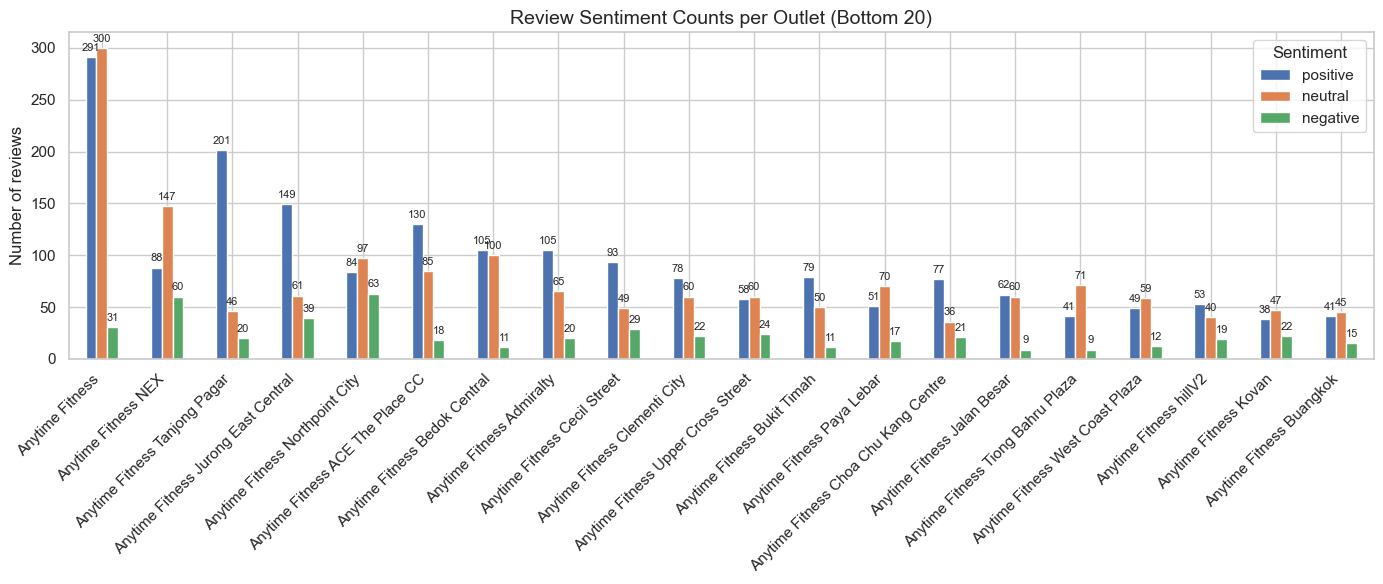

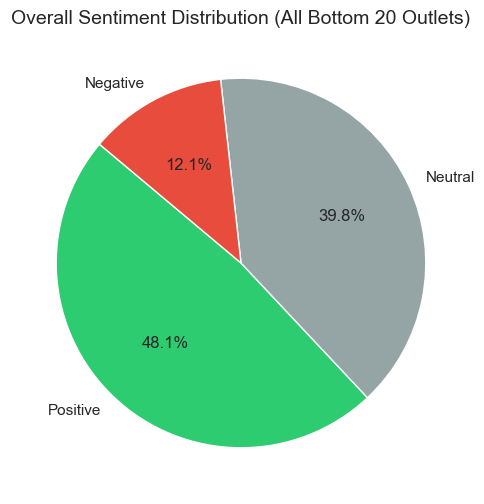

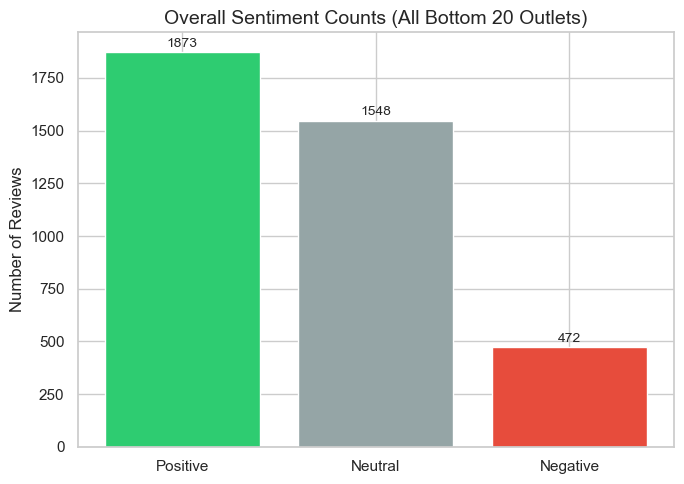

In [47]:
# Plot grouped bars of positive/neutral/negative counts per outlet (top 20)
plot_df = bottom_df[['positive', 'neutral', 'negative']]

ax = plot_df.plot(kind='bar', figsize=(14,6))
ax.set_title('Review Sentiment Counts per Outlet (Bottom 20)', fontsize=14)
ax.set_ylabel('Number of reviews')
ax.set_xlabel('')
ax.legend(title='Sentiment')

plt.xticks(rotation=45, ha='right')

# annotate each bar with its count
for p in ax.patches:
    height = p.get_height()
    if height is None:
        continue
    # skip zero-height bars if you prefer
    if height != 0:
        ax.annotate(f'{int(height)}',
                    xy=(p.get_x() + p.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# --- OVERALL SENTIMENT SPLIT (Pie + Bar) ---
# Sum the sentiment counts across all bottom 20 outlets
total_positive = bottom_df['positive'].sum()
total_neutral = bottom_df['neutral'].sum()
total_negative = bottom_df['negative'].sum()

# Create dictionary of totals
sentiment_totals = {
    'Positive': total_positive,
    'Neutral': total_neutral,
    'Negative': total_negative
}

# --- PIE CHART ---
plt.figure(figsize=(6,6))
plt.pie(
    sentiment_totals.values(),
    labels=sentiment_totals.keys(),
    autopct='%1.1f%%',
    startangle=140,
    colors=['#2ecc71', '#95a5a6', '#e74c3c']
)
plt.title('Overall Sentiment Distribution (All Bottom 20 Outlets)', fontsize=14)
plt.show()

# --- BAR CHART ---
plt.figure(figsize=(7,5))
plt.bar(sentiment_totals.keys(), sentiment_totals.values(), color=['#2ecc71', '#95a5a6', '#e74c3c'])
plt.title('Overall Sentiment Counts (All Bottom 20 Outlets)', fontsize=14)
plt.ylabel('Number of Reviews')

# Add text labels above bars
for i, (sentiment, count) in enumerate(sentiment_totals.items()):
    plt.text(i, count + 10, str(int(count)), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()